## 1. Loading Libraries and Datasets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import re

# Load Excel workbook
file_path = r'C:\Users\user\Desktop\Data_Analyst\TDN_Network\TDN_Alpha_and_Access\AI_Showcase_Virtual_Conf_Full_attendee_list.xlsx'
excel_file = pd.ExcelFile(file_path)
all_sheets = pd.read_excel(file_path, sheet_name=None)

# Extract relevant sheets
df_attendees = all_sheets['Full list of attendees']
df_companies = all_sheets['Companies seeking AI automation']
df_freelancers = all_sheets['AI freelancers & agencies for a']
df_investors = all_sheets['AI investors']
df_startups = all_sheets['AI startups']


## 2. Data Cleanup

### 2.1 Founders – Define & Clean Needs

In [2]:
founders_df = df_attendees.copy()

columns_to_check = [
    'Processes looking to be automated with AI',
    'Interested in AI automation services for the company\n(391)',
    'Interested in educating their team on using AI in their job\n(333)',
    'Interested in taking an AI automation course themselves\n(402)'
]

def compile_needs(row):
    needs = []
    process_value = str(row['Processes looking to be automated with AI']).strip().lower()
    if process_value and process_value not in ['-', 'not sure', 'none', 'nan', 'general']:
        needs.append("Process Automation")

    def is_true(val):
        return str(val).strip().lower() in ['yes', 'true', '1']

    if is_true(row.get(columns_to_check[1])): needs.append("AI Services")
    if is_true(row.get(columns_to_check[2])): needs.append("Team AI Education")
    if is_true(row.get(columns_to_check[3])): needs.append("Personal AI Training")
    return needs

founders_df['founders_needs'] = founders_df.apply(compile_needs, axis=1)

# Mark booleans
founders_df['Wants_Service'] = founders_df[columns_to_check[1]].notna()
founders_df['Wants_Team_Education'] = founders_df[columns_to_check[2]].notna()
founders_df['Wants_Personal_Course'] = founders_df[columns_to_check[3]].notna()

# Assign Primary Need
def get_primary_need(row):
    if pd.notna(row['Processes looking to be automated with AI']):
        return 'Process Automation'
    elif row[columns_to_check[2]] == True:
        return 'Team AI Education'
    elif row[columns_to_check[3]] == True:
        return 'Personal AI Training'
    elif row[columns_to_check[1]] == True:
        return 'AI Services'
    return 'Unspecified'

founders_df['Primary_Need'] = founders_df.apply(get_primary_need, axis=1)
founders_df = founders_df[founders_df['Primary_Need'] != 'Unspecified']


### 2.2 Investors – Classify Stage Focus

In [3]:
investment_columns = [
    'Looking to invest in Pre-seed Startups\n(198)',
    'Looking to invest in Seed Startups\n(226)',
    'Looking to invest in Series A Startups\n(115)',
    'Looking to invest in Series B Startups\n(51)',
    'Looking to invest in Series C+ Startups\n(5)'
]

def classify_investor(row):
    if row[investment_columns[4]] == 1: return 'Series C+'
    elif row[investment_columns[3]] == 1: return 'Series B'
    elif row[investment_columns[2]] == 1: return 'Series A'
    elif row[investment_columns[1]] == 1: return 'Seed'
    elif row[investment_columns[0]] == 1: return 'Pre-seed'
    return 'Unspecified'

df_investors_filtered = df_investors[['Name', 'Email', 'Company Name'] + investment_columns]
df_investors_filtered['Focus Stage'] = df_investors_filtered.apply(classify_investor, axis=1)


C:\Users\user\AppData\Local\Temp\ipykernel_3604\1074150701.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_investors_filtered['Focus Stage'] = df_investors_filtered.apply(classify_investor, axis=1)


### 2.3 Startups – Classify Stage

In [4]:
startup_stage_columns = [
    'Bootstrapped\n(195)', 'Pre-seed\n(109)', 'Seed\n(149)',
    'Series A\n(8)', 'Series B\n(8)', 'Series C+\n(3)'
]

def classify_startup(row):
    if row[startup_stage_columns[5]] == 1: return 'Series C+'
    elif row[startup_stage_columns[4]] == 1: return 'Series B'
    elif row[startup_stage_columns[3]] == 1: return 'Series A'
    elif row[startup_stage_columns[2]] == 1: return 'Seed'
    elif row[startup_stage_columns[1]] == 1: return 'Pre-seed'
    elif row[startup_stage_columns[0]] == 1: return 'Bootstrapped'
    return 'Unspecified'

df_startups_filtered = df_startups[['Name', 'Email', 'Company Name'] + startup_stage_columns]
df_startups_filtered['Stage'] = df_startups_filtered.apply(classify_startup, axis=1)


C:\Users\user\AppData\Local\Temp\ipykernel_3604\1982750654.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_startups_filtered['Stage'] = df_startups_filtered.apply(classify_startup, axis=1)


### 2.4 Freelancers – Clean Tool Column

In [5]:
df_freelancers.rename(columns={'AI tools used to automate client processes': 'Tools'}, inplace=True)

ignore_vals = ['none', 'none at the moment', 'normal gpts for now', 'n/a', 'na', 'fg', 'social', 'pp']
all_tools = []

for entry in df_freelancers['Tools'].dropna():
    entry = str(entry).lower().strip()
    if entry in ignore_vals:
        continue
    entry = re.sub(r'\band\b|\/|\+|&|;|:', ',', entry)
    tools = [tool.strip() for tool in entry.split(',') if tool.strip()]
    all_tools.extend(tools)


## 3. Data Analysis

### 3.1 Founder Needs Summary

In [6]:
summary = {
    'Wants_Service': founders_df['Wants_Service'].sum(),
    'Wants_Team_Education': founders_df['Wants_Team_Education'].sum(),
    'Wants_Personal_Course': founders_df['Wants_Personal_Course'].sum()
}
print("Summary of Founder Needs:", summary)

founders_df.to_excel('Cleaned_Data/founders_needs_summary.xlsx', index=False)

Summary of Founder Needs: {'Wants_Service': np.int64(2055), 'Wants_Team_Education': np.int64(2055), 'Wants_Personal_Course': np.int64(2055)}


### 3.2 Matching

- Match Startups to Investors by Stage

In [7]:
investors = df_investors_filtered.rename(columns={
    'Name': 'Investor Name', 'Email': 'Investor Email', 'Company Name': 'Investor Company'
})[['Investor Name', 'Investor Email', 'Investor Company', 'Focus Stage']]

startups = df_startups_filtered.rename(columns={
    'Name': 'Startup Name', 'Email': 'Startup Email', 'Company Name': 'Startup Company'
})[['Startup Name', 'Startup Email', 'Startup Company', 'Stage']]

matched_investor_startups = pd.merge(startups, investors, left_on='Stage', right_on='Focus Stage', how='inner')
matched_investor_startups.to_excel('Cleaned_Data/matched_investors_to_startups.xlsx', index=False)


- Match Freelancers to Founders

In [8]:
freelancers = df_freelancers[df_freelancers['Interested in AI automation services for the company\n(70)'] == 1][
    ['Name', 'Email', 'Company Name', 'Tools']
]
founders_wanting_services = founders_df[founders_df['Wants_Service'] == 1][['Name', 'Company Name']]
founders_wanting_services['key'] = freelancers['key'] = 1

matches_founders_freelancers = pd.merge(founders_wanting_services, freelancers, on='key').drop(columns='key')
matches_founders_freelancers.to_excel('Cleaned_Data/founders_freelancers_matches.xlsx', index=False)


## 4. Data Visualization

### 4.1 Founders – Needs Overview

C:\Users\user\AppData\Local\Temp\ipykernel_3604\1397001284.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Need', data=needs_df, palette='coolwarm')


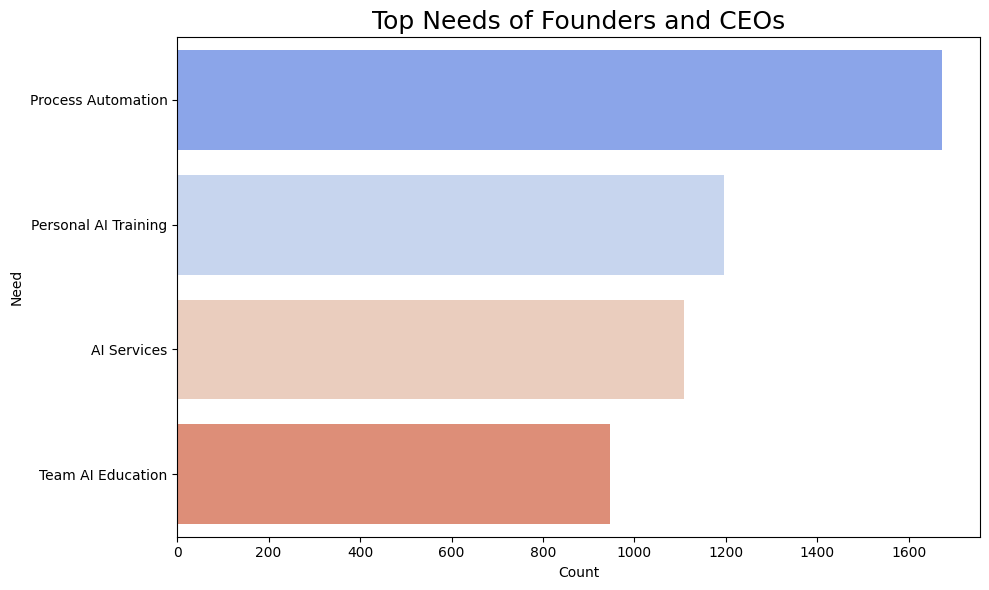

In [9]:
# Barplot for needs
needs_df = pd.DataFrame(Counter([n for sublist in founders_df['founders_needs'] for n in sublist]).items(),
                        columns=['Need', 'Count']).sort_values(by='Count', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Count', y='Need', data=needs_df, palette='coolwarm')
plt.title('Top Needs of Founders and CEOs', fontsize=18)
plt.tight_layout()
plt.savefig("images/founders_needs.png", dpi=300, bbox_inches='tight')


### 4.2 Primary Need Distribution

C:\Users\user\AppData\Local\Temp\ipykernel_3604\3735612815.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=founders_df, x='Primary_Need', order=founders_df['Primary_Need'].value_counts().index, palette='viridis')


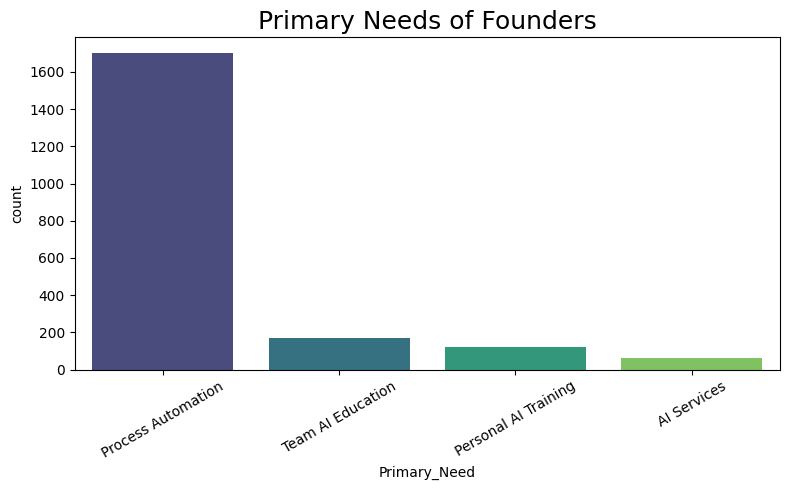

In [10]:
plt.figure(figsize=(8, 5))
sns.countplot(data=founders_df, x='Primary_Need', order=founders_df['Primary_Need'].value_counts().index, palette='viridis')
plt.title('Primary Needs of Founders', fontsize=18)
plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig('images/founders_primary_needs.png', dpi=300, bbox_inches='tight')


### 4.3 Investors and Startups

- Drop 'Unspecified' from both datasets before plotting

In [11]:
df_investors_filtered = df_investors_filtered[df_investors_filtered['Focus Stage'].str.lower() != 'unspecified']
df_startups_filtered = df_startups_filtered[df_startups_filtered['Stage'].str.lower() != 'unspecified']

- Investor Focus by Stage

C:\Users\user\AppData\Local\Temp\ipykernel_3604\1464052504.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_investors_filtered, x='Focus Stage', palette='magma')


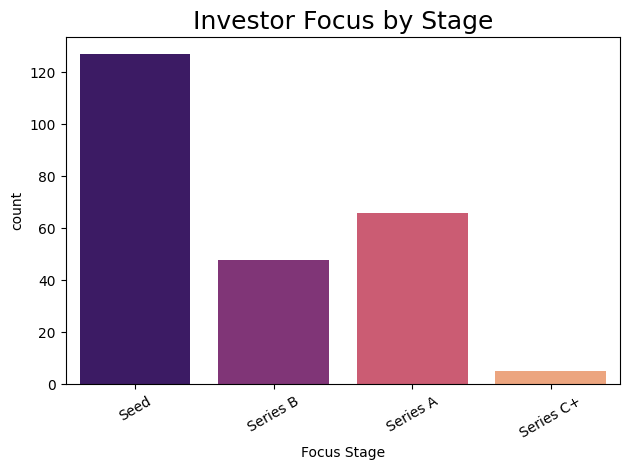

In [12]:
sns.countplot(data=df_investors_filtered, x='Focus Stage', palette='magma')
plt.title('Investor Focus by Stage', fontsize=18)
plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig('images/investor_focus_stage.png', dpi=300, bbox_inches='tight')

- Startup Fundraising Stage Distribution

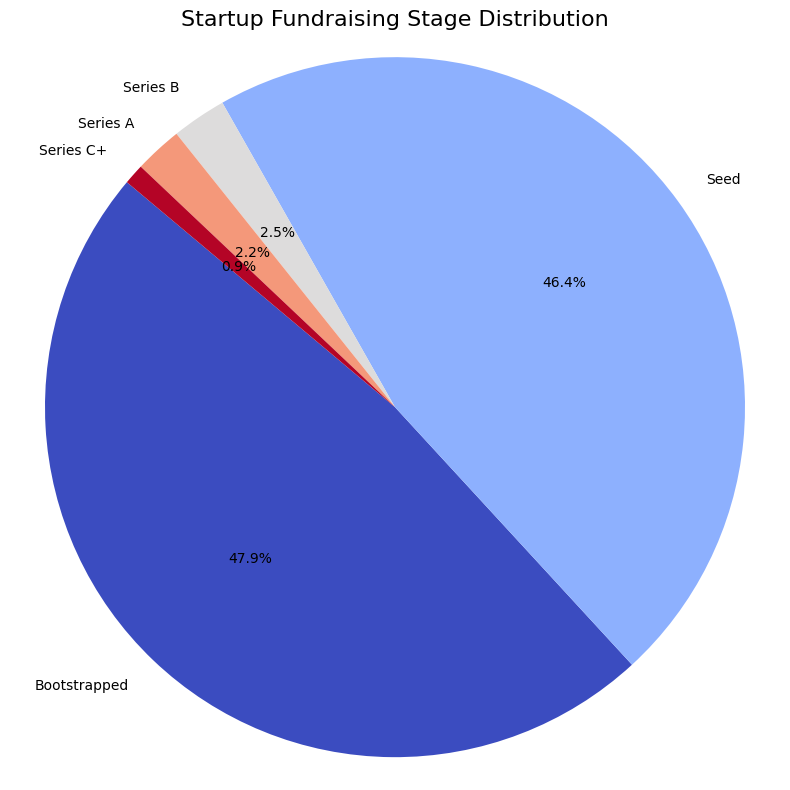

In [13]:
# Count the number of startups at each stage
stage_counts = df_startups_filtered['Stage'].value_counts()
num_stages = len(stage_counts)

# Generate colors from the 'coolwarm' colormap
colors = plt.cm.coolwarm(np.linspace(0, 1, num_stages))

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(stage_counts, labels=stage_counts.index, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Startup Fundraising Stage Distribution', fontsize=16)
plt.axis('equal')  # Equal aspect ratio ensures the pie is a circle
plt.tight_layout()
plt.savefig('images/startup_stage_piechart.png', dpi=300, bbox_inches='tight')
plt.show()

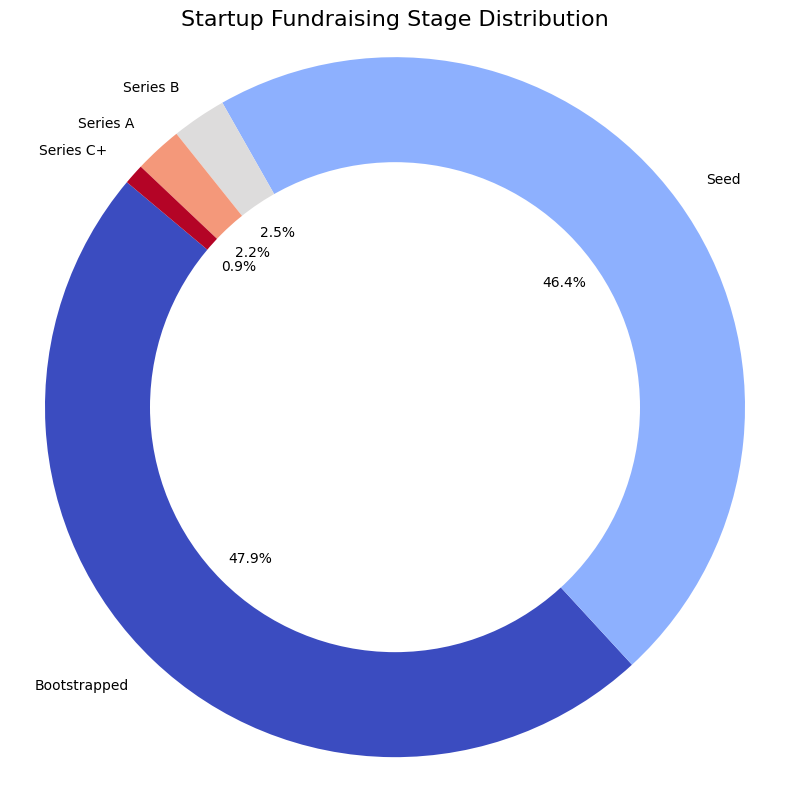

In [14]:
# Count the number of startups at each stage
stage_counts = df_startups_filtered['Stage'].value_counts()
num_stages = len(stage_counts)

# Generate colors from the 'coolwarm' colormap
colors = plt.cm.coolwarm(np.linspace(0, 1, num_stages))

# Create the donut chart
plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(
    stage_counts, 
    labels=stage_counts.index, 
    autopct='%1.1f%%', 
    startangle=140, 
    colors=colors, 
    textprops={'fontsize': 10}
)

# Draw a circle at the center to make it a donut
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
plt.gca().add_artist(centre_circle)

# Title and layout
plt.title('Startup Fundraising Stage Distribution', fontsize=16)
plt.axis('equal')  # Equal aspect ratio ensures the pie is a circle
plt.tight_layout()

# Save the figure
plt.savefig('images/startup_stage_donut.png', dpi=300, bbox_inches='tight')
plt.show()


### 4.4 Freelancer Tool Usage

C:\Users\user\AppData\Local\Temp\ipykernel_3604\1807629744.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_tools.values, y=top_tools.index, palette="mako")


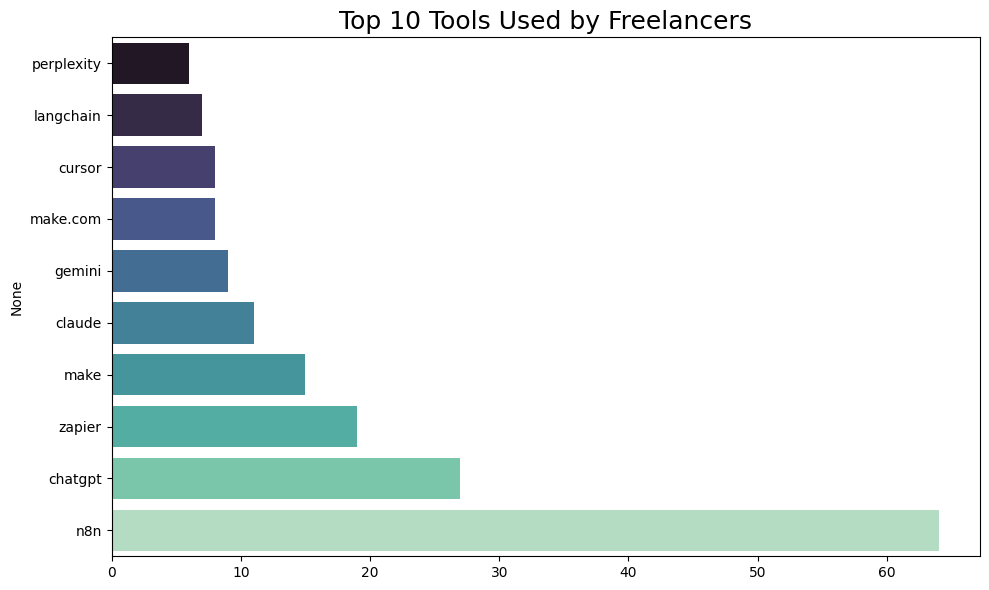

In [15]:
top_tools = pd.Series(Counter(all_tools)).sort_values(ascending=True).tail(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_tools.values, y=top_tools.index, palette="mako")
plt.title("Top 10 Tools Used by Freelancers", fontsize=18)
plt.tight_layout()
plt.savefig("images/top_freelancer_tools.png", dpi=300, bbox_inches='tight')

### 4.5 Startup Stage by Region

- Identify Regions and Startups

In [16]:
# Clean column names first
df_startups.columns = df_startups.columns.str.strip().str.replace(r'\n\(\d+\)', '', regex=True)

# Cleaned columns
startup_stage_columns = ['Bootstrapped', 'Pre-seed', 'Seed', 'Series A', 'Series B', 'Series C+']
region_cols = [
    'Globally – everywhere', 'US', 'Canada', 'UK', 'Europe', 'Israel',
    'Latin America', 'Middle East', 'Africa', 'Asia Pacific', 'Other regions'
]

# Melt into long format
df_stage = df_startups.melt(id_vars=['Name'], value_vars=startup_stage_columns, var_name='Stage', value_name='HasStage')
df_region = df_startups.melt(id_vars=['Name'], value_vars=region_cols, var_name='Region', value_name='HasRegion')

# Filter only where selected
df_stage = df_stage[df_stage['HasStage'] == 1]
df_region = df_region[df_region['HasRegion'] == 1]

- Merge

In [17]:
# Merge by Name
df_stage_region = pd.merge(df_stage[['Name', 'Stage']], df_region[['Name', 'Region']], on='Name')

- Visualize

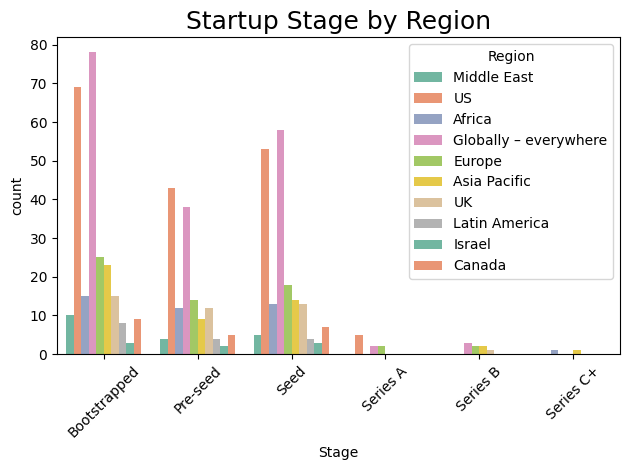

In [18]:
# Plot
sns.countplot(data=df_stage_region, x='Stage', hue='Region', palette='Set2')
plt.title("Startup Stage by Region", fontsize=18)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("images/startup_stage_region.png", dpi=300, bbox_inches='tight')
plt.show()

### 4.6 Investor AI Needs

In [19]:
df_investors.rename(columns={
    'Interested in AI automation services for the company\n(102)': 'AI_Automation_Services',
    'Interested in educating their team on using AI in their job\n(83)': 'AI_Team_Education',
    'Interested in taking an AI automation course themselves\n(109)': 'AI_Course_Self'
}, inplace=True)

ai_cols = ['AI_Automation_Services', 'AI_Team_Education', 'AI_Course_Self']

# Convert to binary: 1 if not null (or Yes), 0 otherwise
df_investors[ai_cols] = df_investors[ai_cols].notna().astype(int)

df_investors['Total_AI_Needs'] = df_investors[ai_cols].sum(axis=1)

C:\Users\user\AppData\Local\Temp\ipykernel_3604\1233412609.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_investors, x='Total_AI_Needs', palette='viridis')


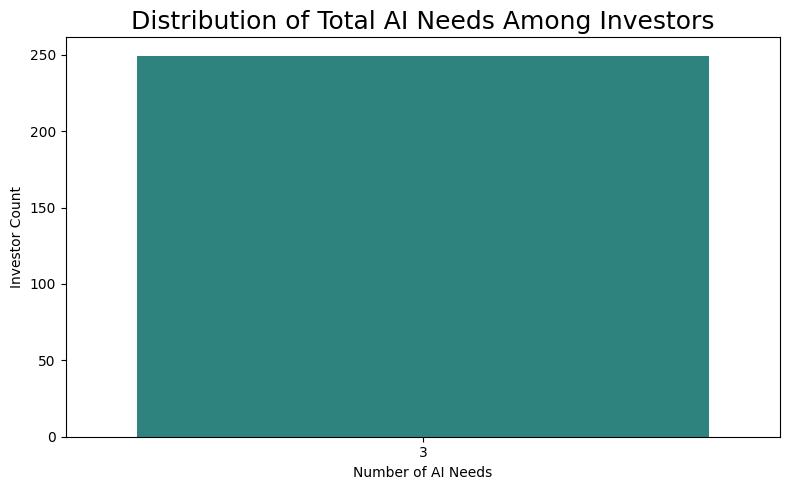

In [20]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df_investors, x='Total_AI_Needs', palette='viridis')
plt.title('Distribution of Total AI Needs Among Investors', fontsize=18)
plt.xlabel('Number of AI Needs')
plt.ylabel('Investor Count')
plt.tight_layout()
plt.savefig('images/investor_ai_needs_distribution.png', dpi=300, bbox_inches='tight')
plt.show()


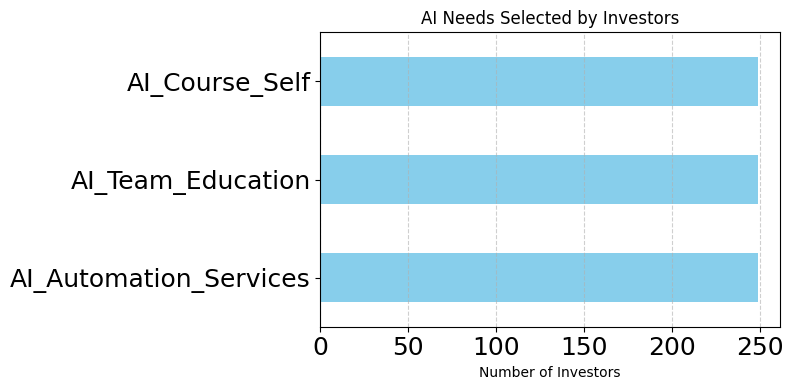

In [21]:
ai_needs = ['AI_Automation_Services', 'AI_Team_Education', 'AI_Course_Self']

df_investors[ai_needs].sum().sort_values().plot(
    kind='barh', color='skyblue', figsize=(8, 4), title='AI Needs Selected by Investors', fontsize=18
)
plt.xlabel("Number of Investors")
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.savefig('images/ai_needs_investor_selected.png', dpi=300, bbox_inches='tight')
plt.show()


### 4.7 Investor Regional Interests

In [22]:
df_investors.rename(columns={
    'Looking to invest in Pre-seed Startups (198)': 'invest_pre_seed',
    'Looking to invest in Seed Startups (226)': 'invest_seed',
    'Looking to invest in Series A Startups (115)': 'invest_series_a',
    'Looking to invest in Series B Startups (51)': 'invest_series_b',
    'Looking to invest in Series C+ Startups (5)': 'invest_series_c_plus',
    'Globally – everywhere (94)': 'region_global'
}, inplace=True)

df_investors.columns = df_investors.columns.str.strip().str.replace('\n', ' ').str.replace(r'\s+', ' ', regex=True)
region_cols = [col for col in df_investors.columns if ' (' in col]
region_counts = df_investors[region_cols].melt(var_name='Region', value_name='Interested')
region_counts = region_counts[region_counts['Interested'] == True]
region_summary = region_counts['Region'].value_counts().sort_values(ascending=False)

C:\Users\user\AppData\Local\Temp\ipykernel_3604\913620194.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=region_summary.values, y=region_summary.index, palette='crest')


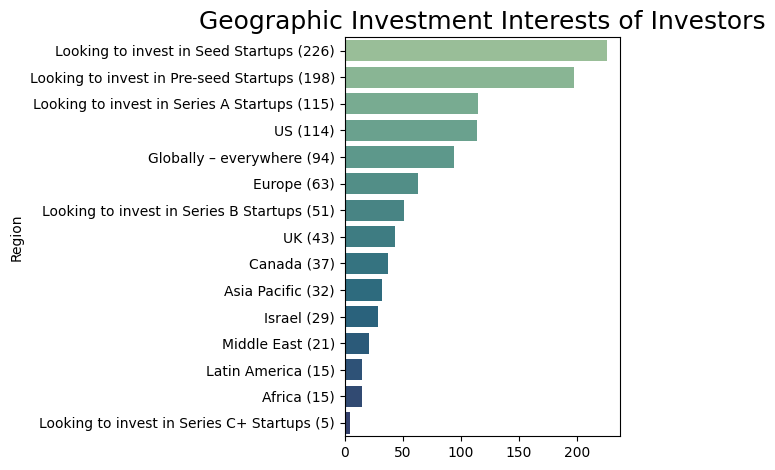

In [23]:
sns.barplot(x=region_summary.values, y=region_summary.index, palette='crest')
plt.title('Geographic Investment Interests of Investors', fontsize=18)
plt.tight_layout()
plt.savefig('images/geographic_investment_interests.png', dpi=300, bbox_inches='tight')


## Who is seeking training or automation? 

In [24]:
# Step 1: Prepare and rename each dataset
founders_df['Source'] = 'Founders'
founders_df['Wants_Automation'] = founders_df['Wants_Service'] == 1
founders_df['Wants_Team_Training'] = founders_df['Wants_Team_Education'] == 1
founders_df['Wants_Personal_Course'] = founders_df['Wants_Personal_Course'] == 1

df_startups['Source'] = 'Startups'
df_startups['Wants_Automation'] = df_startups['Interested in AI automation services for the company'] == 1
df_startups['Wants_Team_Training'] = df_startups['Interested in educating their team on using AI in their job'] == 1
df_startups['Wants_Personal_Course'] = df_startups['Interested in taking an AI automation course themselves'] == 1

df_freelancers['Source'] = 'Freelancers'
df_freelancers['Wants_Automation'] = df_freelancers['Interested in AI automation services for the company\n(70)'] == 1
df_freelancers['Wants_Team_Training'] = df_freelancers['Interested in educating their team on using AI in their job\n(69)'] == 1
df_freelancers['Wants_Personal_Course'] = df_freelancers['Interested in taking an AI automation course themselves\n(115)'] == 1

df_investors['Source'] = 'Investors'
df_investors['Wants_Automation'] = df_investors['AI_Automation_Services'] == 1
df_investors['Wants_Team_Training'] = df_investors['AI_Team_Education'] == 1
df_investors['Wants_Personal_Course'] = df_investors['AI_Course_Self'] == 1

df_companies['Source'] = 'All Companies'
df_companies['Wants_Automation'] = df_companies['Interested in AI automation services for the company\n(655)'] == 1
df_companies['Wants_Team_Training'] = df_companies['Interested in educating their team on using AI in their job\n(370)'] == 1
df_companies['Wants_Personal_Course'] = df_companies['Interested in taking an AI automation course themselves\n(354)'] == 1

# Step 2: Select only necessary columns
cols_to_keep = ['Source', 'Wants_Automation', 'Wants_Team_Training', 'Wants_Personal_Course']
dfs = [
    founders_df[cols_to_keep],
    df_startups[cols_to_keep],
    df_freelancers[cols_to_keep],
    df_investors[cols_to_keep],
    df_companies[cols_to_keep]
]

# Step 3: Combine all into one dataframe
combined_df = pd.concat(dfs, ignore_index=True)

# Step 4: Group and summarize
summary = combined_df.groupby('Source')[
    ['Wants_Automation', 'Wants_Team_Training', 'Wants_Personal_Course']
].sum().astype(int).reset_index()

# Display the summary
print(summary)


          Source  Wants_Automation  Wants_Team_Training  Wants_Personal_Course
0  All Companies               655                  370                    354
1       Founders              2055                 2055                   2055
2    Freelancers                70                   69                    115
3      Investors               249                  249                    249
4       Startups               125                   84                    128


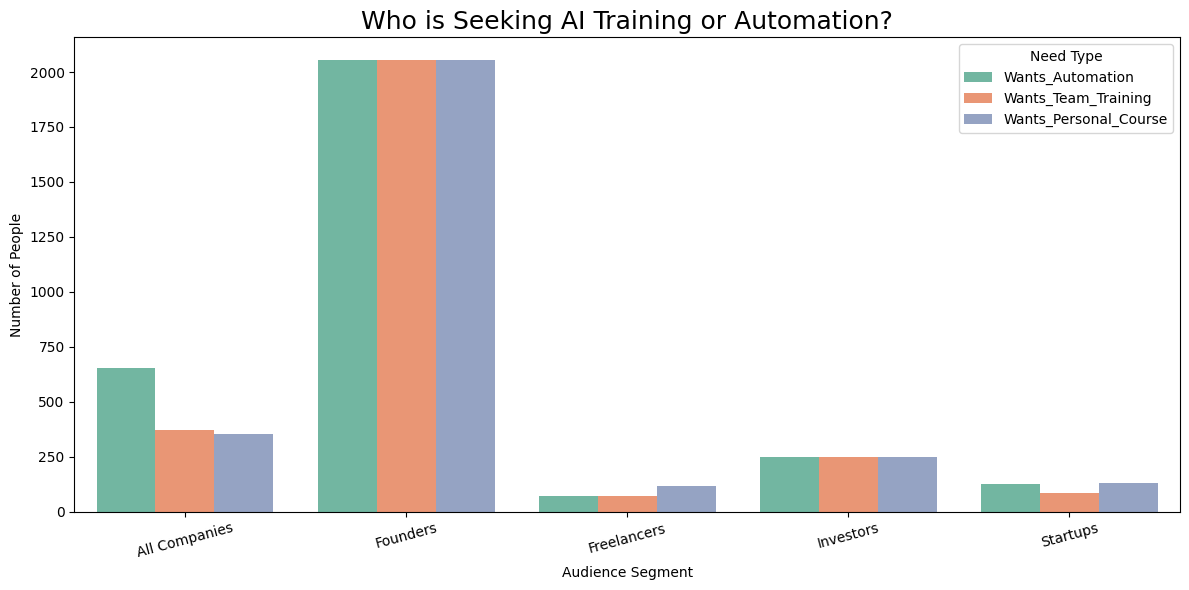

In [25]:
# Data from your table
data = {
    'Source': ['All Companies', 'Founders', 'Freelancers', 'Investors', 'Startups'],
    'Wants_Automation': [655, 2055, 70, 249, 125],
    'Wants_Team_Training': [370, 2055, 69, 249, 84],
    'Wants_Personal_Course': [354, 2055, 115, 249, 128]
}

df = pd.DataFrame(data)

# Melt the data to long format for seaborn
df_melted = df.melt(id_vars='Source', var_name='Need_Type', value_name='Count')

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=df_melted, x='Source', y='Count', hue='Need_Type', palette='Set2')

plt.title('Who is Seeking AI Training or Automation?', fontsize=18)
plt.xlabel('Audience Segment')
plt.ylabel('Number of People')
plt.xticks(rotation=15)
plt.legend(title='Need Type')
plt.tight_layout()
plt.savefig('images/who_wants_what.png', dpi=300, bbox_inches='tight')
plt.show()